# Emission Measure

In [2]:
import os
import sys
import glob

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sunpy.map import Map
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import distributed
import astropy.time
import sunpy.time
import hissw

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube

sys.path.append('../scripts/')
from dem import HannahKontarModel

%matplotlib inline

In [3]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35802 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [3]:
channels = [94,131,171,193,211,335]
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}_frequency/nei/SDO_AIA/{}/map_t{:06d}.fits'

In [9]:
model_cubes = {}
for f in ['high','intermediate','low']:
    model_cubes[f] = DistributedAIACollection(*[DistributedAIACube.from_files([read_template.format(f,c,i)
                                                                               for i in range(500,2500)]) 
                                                for c in channels])

In [5]:
read_template_data = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_201102*_{}_cutout.fits'

In [ ]:
obs_cube = DistributedAIACollection(*[DistributedAIACube.from_files(read_template_data.format(c)) for c in channels])

Next, set up the temperature bins.

In [4]:
temperature_bin_edges = 10.**np.arange(5.3,7.3,0.2) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [3]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [5]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Now, we'll go through each heating case, as well as the observations, and compute the emission measure distribution.

### High

In [52]:
maps = [model_cubes['high'][c].average() for c in channels]

/Users/willbarnes/anaconda/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [53]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/Users/willbarnes/Documents/work/codes/demreg/idl')

In [54]:
em_high = hk_model.fit()

IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 91 to 106
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------

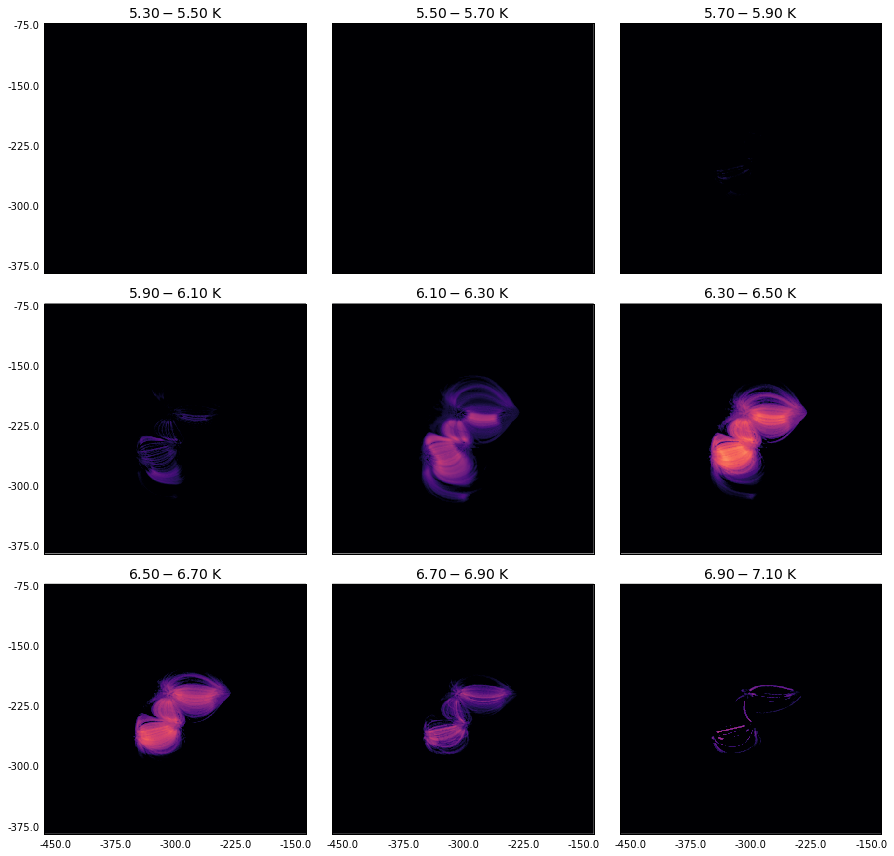

In [77]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_high.maps)):
    tmp = em_high[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

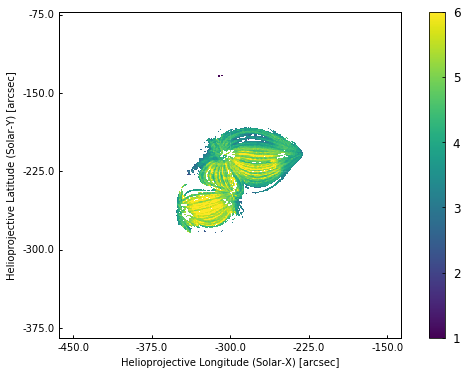

In [81]:
slope_map = em_high.make_slope_map(temperature_bounds=[1,4]*u.MK,em_threshold=1e20*u.cm**-5,rsquared_tolerance=0.9)
slope_map_high = sunpy.map.Map(np.where(slope_map.data == 0, np.nan, slope_map.data),slope_map.meta)
#slope_map = slope_map.submap(SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map.coordinate_frame),
#                             SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map.coordinate_frame))
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map_high)
im = slope_map_high.plot(axes=ax,cmap='viridis',vmin=1,vmax=6,title=False)
fig.colorbar(im,ax=ax)